In [1]:
import weatherAPI
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
weatherAPI.load2('20080417','20080417','247')  # 예시

,location,date,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%)
0,남원,20080417,15.2,10.7,19.9,0.1,70.0,2.1,73.1


In [3]:
AI_occur=pd.read_csv("HPAIOccurlist_final.csv", encoding='utf-8-sig')

In [4]:
AI_occur

,주소,축종,사육\r\n두수,진단일,발생일,지역코드
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210224,20210223,114
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170107,20170103,211
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161212,20161209,95
3,강원도 철원군 갈말읍 강포리,닭-산란계,30000,20161203,20161130,95
4,강원도 춘천시 사북면 지촌리,닭-산란계,48,20080507,20080507,101
...,...,...,...,...,...,...
1117,충청북도 청주시 흥덕구 오송읍 오송리,닭-육계,1500,20161206,20161204,131
1118,충청북도 충주시 대소원면 만정리,닭-토종닭,100,20161208,20161206,127
1119,충청북도 충주시 동량면 대전리,오리-종오리,7600,20210203,20210202,127
1120,충청북도 충주시 소태면 주치리,닭-산란계,550000,20210313,20210311,127


In [5]:
AI_occur=AI_occur.rename(columns={'사육\r\n두수':'사육수'})

In [6]:
AI_occur.head()

,주소,축종,사육수,진단일,발생일,지역코드
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210224,20210223,114
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170107,20170103,211
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161212,20161209,95
3,강원도 철원군 갈말읍 강포리,닭-산란계,30000,20161203,20161130,95
4,강원도 춘천시 사북면 지촌리,닭-산란계,48,20080507,20080507,101


In [7]:
AI_occur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   주소      1122 non-null   object
 1   축종      1122 non-null   object
 2   사육수     1122 non-null   int64 
 3   진단일     1122 non-null   int64 
 4   발생일     1122 non-null   int64 
 5   지역코드    1122 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 52.7+ KB


In [8]:
AI_occur['진단일']=AI_occur['진단일'].astype('str')
AI_occur['발생일']=AI_occur['발생일'].astype('str')
AI_occur['지역코드']=AI_occur['지역코드'].astype('str')

In [9]:
AI_occur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   주소      1122 non-null   object
 1   축종      1122 non-null   object
 2   사육수     1122 non-null   int64 
 3   진단일     1122 non-null   object
 4   발생일     1122 non-null   object
 5   지역코드    1122 non-null   object
dtypes: int64(1), object(5)
memory usage: 52.7+ KB


In [10]:
local=pd.read_excel("localcode.xlsx")

In [11]:
local.head()

,지점,지점명
0,90,속초
1,93,북춘천
2,95,철원
3,98,동두천
4,99,파주


In [12]:
localMatch={}
for i in range(len(local)):
    localMatch[local.loc[i,'지점']]=local.loc[i,'지점명']

In [13]:
localMatch[90]

'속초'

In [14]:
# 지역코드랑 지역명 매칭 (주소랑 다른 경우는 날씨 데이터의 지역코드가 없어 인접 지역으로 선정)
AI_occur['지역명']=np.nan
for i in range(len(AI_occur)):
    AI_occur.loc[i,'지역명']=localMatch[int(AI_occur.loc[i,'지역코드'])]

In [15]:
AI_occur.head()

,주소,축종,사육수,진단일,발생일,지역코드,지역명
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210224,20210223,114,원주
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170107,20170103,211,인제
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161212,20161209,95,철원
3,강원도 철원군 갈말읍 강포리,닭-산란계,30000,20161203,20161130,95,철원
4,강원도 춘천시 사북면 지촌리,닭-산란계,48,20080507,20080507,101,춘천


### 관계성 분석 v1 (시계열 분석)
#### 1. 지역별 발생 주기 알아보기
    1.1. 주소별 발생일 분리 후 평균 발생주기(년)을 구함

In [16]:
# 시군구까지로 지역을 나눔
AI_occur['시도']=np.nan
AI_occur['시군구']=np.nan
for i in range(len(AI_occur)):
    temp=AI_occur.loc[i,'주소'].split()
    AI_occur.loc[i,'시도']=temp[0] # 시도
    if len(temp[0])<=4: #특별, 광역시 아닌 경우
        AI_occur.loc[i,'시군구']=temp[1]
    else: # 특별, 광역시인 경우 그대로 들어감
        AI_occur.loc[i,'시군구']=temp[0]

In [17]:
AI_occur.head()

,주소,축종,사육수,진단일,발생일,지역코드,지역명,시도,시군구
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210224,20210223,114,원주,강원도,원주시
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170107,20170103,211,인제,강원도,인제군
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161212,20161209,95,철원,강원도,철원군
3,강원도 철원군 갈말읍 강포리,닭-산란계,30000,20161203,20161130,95,철원,강원도,철원군
4,강원도 춘천시 사북면 지촌리,닭-산란계,48,20080507,20080507,101,춘천,강원도,춘천시


In [18]:
local_key={} # 해당 시군구와 시도 인접
for i in range(len(AI_occur)):
    local_key[AI_occur.loc[i,'시군구']]=AI_occur.loc[i,'시도']

In [19]:
local_data={}
local_period_y={}
for n1, group in AI_occur.groupby(['시군구']):
    group=group.sort_values(['발생일']) # 발생일 기준 오름차순
    group.reset_index(inplace=True, drop=True)
    temp=[]  
    # 평균 발생주기(년) 구하기
    if len(group)>1: # 발생건수가 2개이상 있는 경우
        for i in range(1,len(group)):
            datey=datetime.datetime.strptime(group.loc[i-1,'발생일'], '%Y%m%d')
            datet=datetime.datetime.strptime(group.loc[i,'발생일'], '%Y%m%d')
            diff = datet.year-datey.year
            if diff!=0:  #차이가 0인 것은 같은 발생건수로 인식
                temp.append(diff)
        if len(temp)>0:
            temp=np.array(temp)
            local_period_y[n1]=np.round(np.mean(temp),1)
        else:
            local_period_y[n1]=-1.0
    else: # 발생건수가 1개일 경우 (-1로 인식)
        local_period_y[n1]=-1.0
    local_data[n1]=group

In [20]:
local_data.keys()

dict_keys(['강진군', '거창군', '경산시', '경주시', '고성군', '고양시', '고창군', '고흥군', '곡성군', '공주시', '과천시', '광주광역시', '광주시', '괴산군', '구례군', '구미시', '군산시', '김제시', '김포시', '나주시', '남양주시', '남원시', '논산시', '담양군', '당진시', '대구광역시', '동두천시', '무안군', '문경시', '밀양시', '보성군', '부산광역시', '부안군', '부여군', '상주시', '서산시', '서울특별시', '서천군', '성남시', '성주군', '세종특별자치시', '수원시', '순창군', '순천시', '신안군', '아산시', '안성시', '양산시', '양주시', '양평군', '여수시', '여주시', '연천군', '영광군', '영암군', '영주시', '영천시', '예산군', '옥천군', '완주군', '용인시', '울산광역시', '원주시', '음성군', '의정부시', '이천시', '익산시', '인제군', '인천광역시', '임실군', '장성군', '장흥군', '전주시', '정읍시', '제주특별자치도', '증평군', '진도군', '진안군', '진주시', '진천군', '천안시', '철원군', '청양군', '청원군', '청주시', '춘천시', '충주시', '통영시', '파주시', '평택시', '포천시', '포항시', '하동군', '함평군', '해남군', '홍성군', '화성시', '화순군', '횡성군'])

In [21]:
local_data['강진군']

,주소,축종,사육수,진단일,발생일,지역코드,지역명,시도,시군구
0,전라남도 강진군 성전면 금당리,오리-육용오리,1,20140507,20140504,259,강진군,전라남도,강진군
1,전라남도 강진군 성전면 금당리,오리-종오리,15000,20150513,20150428,259,강진군,전라남도,강진군
2,전라남도 강진군 칠량면 삼흥리,오리-육용오리,6850,20150918,20150914,259,강진군,전라남도,강진군
3,전라남도 강진군 강진읍 덕남리,닭-기타,60,20150928,20150921,259,강진군,전라남도,강진군
4,전라남도 강진군 신전면 송천리,오리-육용오리,8800,20170228,20170226,259,강진군,전라남도,강진군
5,전라남도 강진군 도암면 석문리,오리-육용오리,22400,20170307,20170305,259,강진군,전라남도,강진군
6,전라남도 강진군 도암면 석문리,오리-종오리,8000,20170309,20170306,259,강진군,전라남도,강진군
7,전라남도 강진군 도암면 석문리,오리-육용오리,40000,20170309,20170306,259,강진군,전라남도,강진군
8,전라남도 강진군 성전면 금당리,오리-종오리,16800,20170313,20170309,259,강진군,전라남도,강진군
9,전라남도 강진군 작천면 갈동리,오리-종오리,22000,20180105,20180104,259,강진군,전라남도,강진군


In [22]:
local_period_y['고성군']

2.0

In [23]:
local_period_df=pd.DataFrame.from_dict(local_period_y, orient='index', columns=['period_year'])

In [24]:
local_period_df.reset_index(inplace=True)

In [25]:
local_period_df=local_period_df.rename(columns={'index':'시군구'})

In [26]:
local_period_df['시도']=np.nan
for i in range(len(local_period_df)):
    local_period_df.loc[i,'시도']=local_key[local_period_df.loc[i,'시군구']]

In [27]:
local_period_df.head()

,시군구,period_year,시도
0,강진군,1.3,전라남도
1,거창군,-1.0,경상남도
2,경산시,-1.0,경상북도
3,경주시,8.5,경상북도
4,고성군,2.0,경상남도


In [28]:
lp_df=local_period_df.query('period_year>-1.0')  # -1.0은 제거 (주기 없는 것)

In [29]:
lp_df.to_csv('local_period.csv', index=False, encoding='utf-8-sig')

In [30]:
# 전국 평균 발생 주기
np.round(lp_df['period_year'].mean(),1)

3.0

In [31]:
lp_df.describe()

,period_year
count,61.000000
mean,2.988525
std,1.438877
min,1.000000
25%,2.000000
50%,3.000000
75%,3.500000
max,8.500000


In [32]:
# 시도 단위로 보기
lp_df_sido=lp_df[['시도','period_year']]
lp_df_sido=np.round(lp_df_sido.groupby('시도').mean(),1)
lp_df_sido.reset_index(inplace=True)

In [33]:
lp_df_sido

,시도,period_year
0,강원도,3.0
1,경기도,2.7
2,경상남도,2.7
3,경상북도,5.8
4,대구광역시,4.5
5,부산광역시,3.0
6,세종특별자치시,3.5
7,울산광역시,3.5
8,인천광역시,2.0
9,전라남도,2.9


In [121]:
lp_df_sido.describe()

,period_year
count,14.000000
mean,3.335714
std,0.974764
min,2.000000
25%,2.700000
50%,3.000000
75%,3.800000
max,5.800000


In [34]:
from matplotlib import font_manager, rc
font_list = font_manager.findSystemFonts(fontpaths= None, fontext = 'ttf')
path='C:\\Windows\\Fonts\\gulim.ttc'
fontname = font_manager.FontProperties(fname=path).get_name()
plt.rc('font', family=fontname)

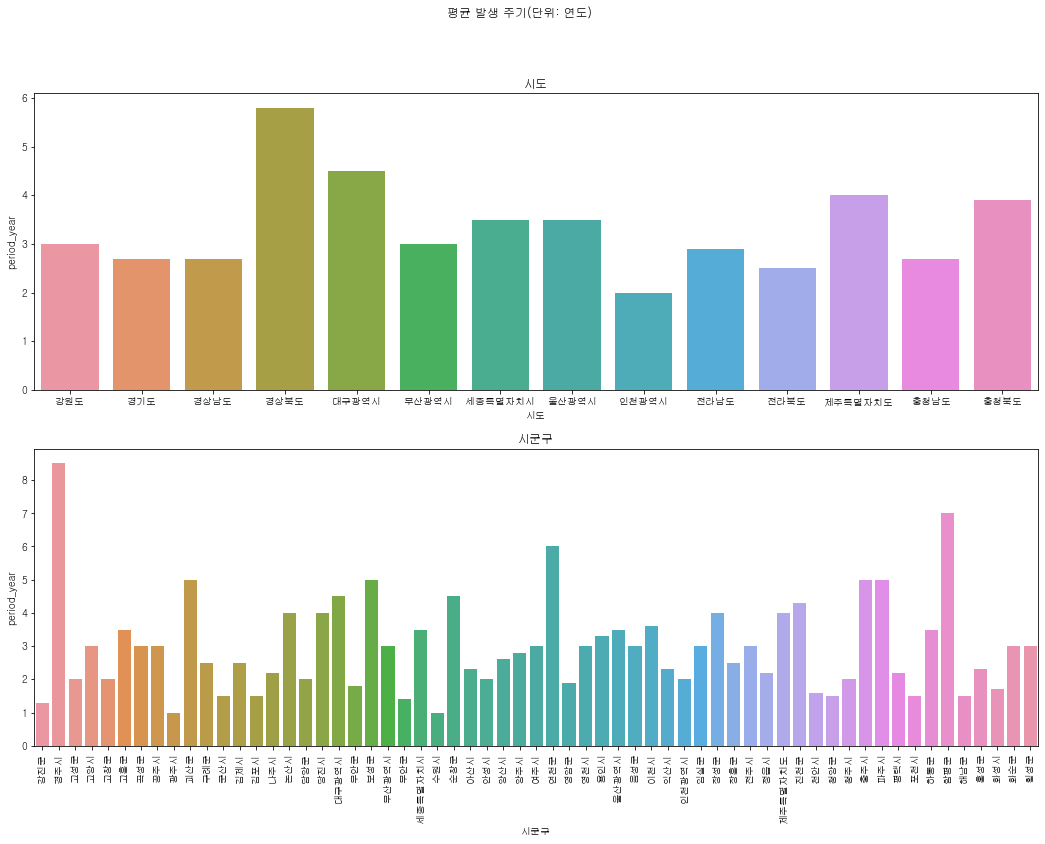

In [35]:
f, ax = plt.subplots(2, figsize=(18,12))

sns.barplot(x = "시도", y = "period_year",data = lp_df_sido, ax = ax[0])
sns.barplot(x = "시군구", y = "period_year",data = lp_df, ax = ax[1])
plt.xticks(rotation=90)
ax[0].set_title("시도")
ax[1].set_title("시군구")
plt.suptitle("평균 발생 주기(단위: 연도)")
plt.show()

#### 2. 사계절을 기준으로 기후 관계성
    2.1. 지역과 관계없이 발병된 일자에 따른 사계절별 기후 분석
    2.2. 발병되지 않은 일자에 따른 사계절별 기후 분석
    
    *** 특정 기후에 따른 기준을 만들기 위해 전체를 사계절로 분류 후 각각의 range 검토 ****


In [36]:
AI_occur.head()

,주소,축종,사육수,진단일,발생일,지역코드,지역명,시도,시군구
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210224,20210223,114,원주,강원도,원주시
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170107,20170103,211,인제,강원도,인제군
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161212,20161209,95,철원,강원도,철원군
3,강원도 철원군 갈말읍 강포리,닭-산란계,30000,20161203,20161130,95,철원,강원도,철원군
4,강원도 춘천시 사북면 지촌리,닭-산란계,48,20080507,20080507,101,춘천,강원도,춘천시


In [37]:
weather_list=['location','date','avg_temp(C)','lowest_temp(C)','highest_temp(C)','daily_rain(mm)',
            'maxWsWd(16방위)','avg_wind(m/s)','avg_r_humidity(%)']
for name in weather_list:
     AI_occur[name]=np.nan
for i in range(len(AI_occur)):
    start=AI_occur.loc[i,'발생일']
    w_data=weatherAPI.load2(start, start, AI_occur.loc[i,'지역코드'])
    try:
        for col in weather_list:
            AI_occur.loc[i,col]=w_data.loc[0,col]
        print('|',end='')
    except:
        print('\n error index:', i)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [38]:
AI_occur.to_csv("HPAI_Weather_occur.csv", index=False, encoding='utf-8-sig')

In [39]:
AI_occur=pd.read_csv("HPAI_Weather_occur.csv", encoding='utf-8-sig')

In [40]:
AI_occur.head()

,주소,축종,사육수,진단일,발생일,지역코드,지역명,시도,시군구,location,date,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%)
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210224,20210223,114,원주,강원도,원주시,원주,20210223,1.9,-1.2,6.4,0.0,270.0,1.4,28.0
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170107,20170103,211,인제,강원도,인제군,인제,20170103,1.2,-4.0,6.2,0.0,160.0,2.2,60.1
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161212,20161209,95,철원,강원도,철원군,철원,20161209,-0.1,-6.3,3.7,1.7,270.0,1.6,68.9
3,강원도 철원군 갈말읍 강포리,닭-산란계,30000,20161203,20161130,95,철원,강원도,철원군,철원,20161130,3.2,-4.7,8.9,1.2,230.0,0.9,72.1
4,강원도 춘천시 사북면 지촌리,닭-산란계,48,20080507,20080507,101,춘천,강원도,춘천시,춘천,20080507,13.2,7.3,20.9,17.0,180.0,0.6,66.1


In [41]:
#의미없는 열 제외
AI_occur.drop(['진단일','location','date'], axis=1, inplace=True)

In [42]:
AI_occur['발생일']=AI_occur['발생일'].astype('str')
AI_occur['지역코드']=AI_occur['지역코드'].astype('str')

In [43]:
AI_occur.head()

,주소,축종,사육수,발생일,지역코드,지역명,시도,시군구,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%)
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210223,114,원주,강원도,원주시,1.9,-1.2,6.4,0.0,270.0,1.4,28.0
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170103,211,인제,강원도,인제군,1.2,-4.0,6.2,0.0,160.0,2.2,60.1
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161209,95,철원,강원도,철원군,-0.1,-6.3,3.7,1.7,270.0,1.6,68.9
3,강원도 철원군 갈말읍 강포리,닭-산란계,30000,20161130,95,철원,강원도,철원군,3.2,-4.7,8.9,1.2,230.0,0.9,72.1
4,강원도 춘천시 사북면 지촌리,닭-산란계,48,20080507,101,춘천,강원도,춘천시,13.2,7.3,20.9,17.0,180.0,0.6,66.1


In [44]:
# 계절 분류 (봄=1, 여름=2, 가을=3, 겨울=4)
AI_occur['season']=np.nan
for i in range(len(AI_occur)):
    date=datetime.datetime.strptime(AI_occur.loc[i,'발생일'], '%Y%m%d')
    month=date.month
    if month>=3 and month<=5:
        AI_occur.loc[i,'season']=1
    elif month>=6 and month<=8:
        AI_occur.loc[i,'season']=2
    elif month>=9 and month<=11:
        AI_occur.loc[i,'season']=3
    else:
        AI_occur.loc[i,'season']=4

In [45]:
AI_occur.head()

,주소,축종,사육수,발생일,지역코드,지역명,시도,시군구,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%),season
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210223,114,원주,강원도,원주시,1.9,-1.2,6.4,0.0,270.0,1.4,28.0,4.0
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170103,211,인제,강원도,인제군,1.2,-4.0,6.2,0.0,160.0,2.2,60.1,4.0
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161209,95,철원,강원도,철원군,-0.1,-6.3,3.7,1.7,270.0,1.6,68.9,4.0
3,강원도 철원군 갈말읍 강포리,닭-산란계,30000,20161130,95,철원,강원도,철원군,3.2,-4.7,8.9,1.2,230.0,0.9,72.1,3.0
4,강원도 춘천시 사북면 지촌리,닭-산란계,48,20080507,101,춘천,강원도,춘천시,13.2,7.3,20.9,17.0,180.0,0.6,66.1,1.0


In [46]:
season_total={}
season_desc={}
for n1, group in AI_occur.groupby(['season']):
    group.reset_index(drop=True, inplace=True)
    season_total[n1]=group
    season_desc[n1]=group.describe()

In [47]:
season_total.keys()

dict_keys([1.0, 2.0, 3.0, 4.0])

##### (전국 날씨 데이터 이용 후 발생일과 발생되지 않은 날과 비교)

In [80]:
df1=pd.read_csv('weather1.csv', encoding='euc-kr')
df2=pd.read_csv('weather2.csv', encoding='euc-kr')
df3=pd.read_csv('weather3.csv', encoding='euc-kr')
df4=pd.read_csv('weather4.csv', encoding='euc-kr')

In [90]:
df1=df1.rename(columns={'평균기온(℃)':'avg_temperature(C)'})
df2=df2.rename(columns={'평균일강수량(mm)':'daily_rain(mm)'})
df3=df3.rename(columns={'평균풍속(m/s)':'avg_wind(m/s)'})
df4=df4.rename(columns={'평균습도(%rh)':'avg_r_humidity(%)'})

In [92]:
df1['daily_rain(mm)']=df2['daily_rain(mm)']
df1['avg_wind(m/s)']=df3['avg_wind(m/s)']
df1['avg_r_humidity(%)']=df4['avg_r_humidity(%)']

In [99]:
df1['일시']=df1['일시'].map(lambda x: x.replace("-",""))

In [101]:
df1.to_csv("All_weather.csv", index=False, encoding='utf-8-sig')

##### (전국 사계절에 따른 기후 검증 )
    1. 평균온도, 일강수량, 평균풍속, 평균상대습도만을 이용한 비교

In [48]:
allweather=pd.read_csv("All_weather.csv", encoding='utf-8-sig')

,지역명,일시,avg_temperature(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),season
0,전국,20210727,27.8,0.0,1.6,72,2.0
1,전국,20210726,27.8,0.1,1.9,71,2.0
2,전국,20210725,27.8,0.0,1.8,72,2.0
3,전국,20210724,28.0,0.0,1.6,72,2.0
4,전국,20210723,27.7,0.0,1.5,74,2.0
...,...,...,...,...,...,...,...
6778,전국,20030105,-9.4,0.4,4.0,53,4.0
6779,전국,20030104,-6.3,1.7,4.1,61,4.0
6780,전국,20030103,-1.2,1.5,2.5,66,4.0
6781,전국,20030102,-2.5,0.0,1.3,57,4.0


In [50]:
# 발생되지 않은 날씨 기후 판별
occur_day=set(AI_occur['발생일'])
print(f'최소: {min(occur_day)}, 최대: {max(occur_day)}')

최소: 20031212, 최대: 20210406


In [51]:
# 발생된 일자는 제거 하기
for i in range(len(allweather)):
    if allweather.loc[i,'일시'] in occur_day:
        allweather.drop([i], axis=0, inplace=True)

In [52]:
allweather.reset_index(drop=True, inplace=True)

In [53]:
allweather['일시']=allweather['일시'].astype('str')

In [54]:
allweather.describe() #2003~2021년까지 발생일 제외한 전국 평균

,avg_temperature(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%)
count,6783.000000,6783.000000,6783.000000,6783.000000
mean,12.999867,3.621863,1.997980,67.181631
std,9.523829,9.279272,0.703031,12.608563
min,-11.900000,0.000000,0.800000,28.000000
25%,4.700000,0.000000,1.500000,58.000000
50%,13.900000,0.100000,1.800000,68.000000
75%,21.500000,2.050000,2.300000,77.000000
max,30.300000,120.700000,6.800000,96.000000


In [55]:
# 사계절 분리
allweather['season']=np.nan
for i in range(len(allweather)):
    date=datetime.datetime.strptime(allweather.loc[i,'일시'], '%Y%m%d')
    month=date.month
    if month>=3 and month<=5:
        allweather.loc[i,'season']=1
    elif month>=6 and month<=8:
        allweather.loc[i,'season']=2
    elif month>=9 and month<=11:
        allweather.loc[i,'season']=3
    else:
        allweather.loc[i,'season']=4

In [56]:
allweather_total={}
allweather_desc={}
for n1, group in allweather.groupby(['season']):
    group.reset_index(drop=True, inplace=True)
    allweather_total[n1]=group
    allweather_desc[n1]=group.describe()

In [57]:
allweather_desc[1] # 발생 제외 전국 기후 (봄)

,avg_temperature(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),season
count,1748.000000,1748.000000,1748.000000,1748.000000,1748.0
mean,12.267334,2.760984,2.254233,61.014302,1.0
std,5.430436,7.121648,0.690287,12.402398,0.0
min,-2.400000,0.000000,1.100000,31.000000,1.0
25%,8.000000,0.000000,1.700000,52.000000,1.0
50%,12.500000,0.000000,2.100000,60.000000,1.0
75%,16.800000,1.400000,2.600000,69.000000,1.0
max,24.300000,66.500000,6.100000,96.000000,1.0


In [58]:
season_desc[1] # 발생일 전국 기후 (봄)

,사육수,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%),season
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.0
mean,38503.629630,9.068981,3.385648,15.440741,1.850926,231.388889,2.152778,59.894444,1.0
std,94754.078194,5.834565,5.895874,6.716000,5.514438,91.580015,1.134160,15.045400,0.0
min,0.000000,-3.000000,-8.600000,1.500000,0.000000,20.000000,0.600000,22.300000,1.0
25%,8000.000000,4.400000,-1.300000,9.550000,0.000000,180.000000,1.400000,49.100000,1.0
50%,14000.000000,8.500000,3.100000,15.200000,0.000000,270.000000,1.800000,58.450000,1.0
75%,30000.000000,13.725000,8.300000,20.500000,0.500000,270.000000,2.700000,68.650000,1.0
max,920000.000000,23.300000,18.500000,31.800000,46.000000,360.000000,5.700000,96.900000,1.0


In [59]:
allweather_desc[2] # 발생 제외 전국 기후 (여름)

,avg_temperature(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),season
count,1713.000000,1713.000000,1713.000000,1713.000000,1713.0
mean,24.135668,7.623935,1.818564,76.744892,2.0
std,2.625327,13.223981,0.499246,7.963025,0.0
min,15.600000,0.000000,0.900000,44.000000,2.0
25%,22.200000,0.100000,1.500000,72.000000,2.0
50%,23.900000,1.500000,1.700000,77.000000,2.0
75%,26.200000,8.800000,2.000000,82.000000,2.0
max,30.300000,120.700000,6.800000,95.000000,2.0


In [60]:
season_desc[2] # 발생일 전국 기후 (여름)

,사육수,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%),season
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.00000,48.000000,48.0
mean,3182.270833,20.612500,16.831250,25.231250,1.618750,211.875000,2.56875,71.956250,2.0
std,7269.271030,2.857958,3.334102,3.894358,3.370186,81.935529,1.17621,12.986555,0.0
min,1.000000,16.800000,12.000000,19.500000,0.000000,20.000000,1.00000,41.300000,2.0
25%,12.750000,18.600000,14.275000,22.500000,0.000000,175.000000,1.67500,65.450000,2.0
50%,30.500000,20.200000,16.850000,25.250000,0.000000,230.000000,2.40000,69.600000,2.0
75%,1375.000000,21.275000,17.650000,28.200000,3.025000,270.000000,3.10000,85.150000,2.0
max,33300.000000,29.500000,26.500000,36.000000,18.300000,340.000000,5.30000,99.900000,2.0


In [61]:
allweather_desc[3] # 발생 제외 전국 기후 (가을)

,avg_temperature(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),season
count,1638.000000,1638.000000,1638.000000,1638.000000,1638.0
mean,14.699573,3.071795,1.760684,70.835165,3.0
std,5.957329,9.162966,0.646908,10.057607,0.0
min,-1.500000,0.000000,0.800000,32.000000,3.0
25%,10.300000,0.000000,1.300000,65.000000,3.0
50%,15.200000,0.100000,1.600000,72.000000,3.0
75%,19.600000,1.500000,2.000000,77.000000,3.0
max,26.900000,106.300000,5.100000,94.000000,3.0


In [62]:
season_desc[3] # 발생일 전국 기후 (가을)

,사육수,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%),season
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.0
mean,24348.596774,9.458871,4.697581,14.772581,4.869355,199.919355,1.385484,69.560484,3.0
std,70896.864719,7.358641,7.614561,7.722550,26.246447,113.104714,0.654899,16.899573,0.0
min,1.000000,-1.900000,-7.700000,2.900000,0.000000,20.000000,0.600000,0.000000,3.0
25%,6962.500000,2.675000,-2.625000,7.600000,0.000000,90.000000,0.900000,59.200000,3.0
50%,11750.000000,8.700000,3.400000,13.350000,0.000000,230.000000,1.200000,70.250000,3.0
75%,17380.000000,15.400000,9.400000,22.475000,0.600000,290.000000,1.825000,82.650000,3.0
max,700000.000000,22.700000,19.300000,29.200000,170.000000,360.000000,3.600000,99.300000,3.0


In [63]:
allweather_desc[4] # 발생 제외 전국 기후 (겨을)

,avg_temperature(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),season
count,1684.000000,1684.000000,1684.000000,1684.000000,1684.0
mean,0.779394,0.979513,2.145309,60.301663,4.0
std,3.788369,3.229019,0.811787,11.185700,0.0
min,-11.900000,0.000000,0.800000,28.000000,4.0
25%,-1.800000,0.000000,1.500000,52.000000,4.0
50%,0.800000,0.000000,2.000000,60.000000,4.0
75%,3.500000,0.500000,2.600000,67.000000,4.0
max,13.400000,43.000000,5.200000,95.000000,4.0


In [64]:
season_desc[4] # 발생일 전국 기후 (겨을)

,사육수,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%),season
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.0
mean,53342.249319,1.085286,-3.854223,6.661035,0.925749,230.136240,1.696594,64.862125,4.0
std,98075.263555,4.055636,4.419806,4.529974,3.758839,101.061126,1.078793,13.605499,0.0
min,0.000000,-14.500000,-20.100000,-10.900000,0.000000,20.000000,0.400000,0.000000,4.0
25%,9000.000000,-1.400000,-6.575000,3.800000,0.000000,140.000000,0.900000,54.500000,4.0
50%,16000.000000,1.500000,-3.600000,6.700000,0.000000,270.000000,1.400000,64.500000,4.0
75%,43000.000000,3.400000,-1.100000,9.475000,0.100000,320.000000,2.200000,75.400000,4.0
max,788000.000000,12.200000,10.200000,18.900000,63.500000,360.000000,9.100000,99.600000,4.0


###### (평균 온도 검증)
    1. 가정: 계절별 HPAI가 발생하지 않은 날짜의 평균 온도는 HPAI 발생한 날짜의 평균 온도와 차이가 있을 것이다. 
    2. 귀무가설: 두 변수의 차이는 0의 근접할 것이다.
    3. 대립가설: 두 변수의 차이가 0에 근접하지 않을 것이다.

In [121]:
# 겨울일 경우
avg_temp_all=allweather_total[4][['avg_temperature(C)']]

In [283]:
allweather_total[4]   #월별로 평균을 뽑고, 

,지역명,일시,avg_temperature(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),season
0,전국,20210228,7.3,0.2,1.5,67,4.0
1,전국,20210227,7.2,0.2,3.1,57,4.0
2,전국,20210226,7.6,0.7,2.5,59,4.0
3,전국,20210225,4.2,3.4,1.2,69,4.0
4,전국,20210224,3.3,0.0,1.3,46,4.0
...,...,...,...,...,...,...,...
1679,전국,20030105,-9.4,0.4,4.0,53,4.0
1680,전국,20030104,-6.3,1.7,4.1,61,4.0
1681,전국,20030103,-1.2,1.5,2.5,66,4.0
1682,전국,20030102,-2.5,0.0,1.3,57,4.0


In [269]:
avg_temp_all.head()

,avg_temperature(C)
0,7.3
1,7.2
2,7.6
3,4.2
4,3.3


In [123]:
avg_temp_all.describe()

,avg_temperature(C)
count,1684.000000
mean,0.779394
std,3.788369
min,-11.900000
25%,-1.800000
50%,0.800000
75%,3.500000
max,13.400000


In [143]:
avg_temp_occur=season_total[4][['avg_temp(C)']]

In [285]:
season_total[4]

,주소,축종,사육수,발생일,지역코드,지역명,시도,시군구,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%),season
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210223,114,원주,강원도,원주시,1.9,-1.2,6.4,0.0,270.0,1.4,28.0,4.0
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170103,211,인제,강원도,인제군,1.2,-4.0,6.2,0.0,160.0,2.2,60.1,4.0
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161209,95,철원,강원도,철원군,-0.1,-6.3,3.7,1.7,270.0,1.6,68.9,4.0
3,강원도 횡성군 횡성읍 학곡리,닭-토종닭,13,20170106,114,원주,강원도,횡성군,3.9,0.2,9.5,0.0,360.0,0.6,64.9,4.0
4,경기도 고양시 덕양구 내유동,관상조류-비분류,900,20201228,99,파주,경기도,고양시,2.3,-3.0,9.3,0.0,70.0,0.5,85.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,충청북도 청주시 흥덕구 오송읍 동평리,닭-토종닭,125,20161212,131,청주,충청북도,청주시,2.9,-3.7,9.5,0.0,20.0,1.2,50.4,4.0
730,충청북도 청주시 흥덕구 오송읍 동평리,닭-산란계,173000,20161201,131,청주,충청북도,청주시,5.5,1.0,9.5,0.0,320.0,1.9,56.6,4.0
731,충청북도 청주시 흥덕구 오송읍 오송리,닭-육계,1500,20161204,131,청주,충청북도,청주시,4.3,-0.2,8.4,0.0,20.0,0.6,63.3,4.0
732,충청북도 충주시 대소원면 만정리,닭-토종닭,100,20161206,127,충주,충청북도,충주시,-1.1,-6.2,4.1,0.0,270.0,2.1,49.1,4.0


In [268]:
avg_temp_occur.head()

,avg_temp(C)
0,1.9
1,1.2
2,-0.1
3,3.9
4,2.3


In [145]:
avg_temp_occur.describe()

,avg_temp(C)
count,734.000000
mean,1.085286
std,4.055636
min,-14.500000
25%,-1.400000
50%,1.500000
75%,3.400000
max,12.200000


In [127]:
from scipy import stats

##### 정규성 검정
    1. shapiro-wilk test => 표본이 2000 미만인 dataset에 적합 (stats.shapiro)
    2. kolmogorove-smirnov test => 표본이 2000초과인 dataset에 적합 (stats.kstest)
    > 귀무가설(정규화 따른다), 대립가설(정규화 따르지 않는다)
    
##### 독립성 검정
    chi-squared test => 카이제곱 검정, 관찰된 빈도가 기대되는 빈도와 의미있게 다른지 여부 검증
    pandas 중 pd.crosstab(x,y)의 결과물을 chi2_contingency() 함수로 입력
    결과물 > (검정통계량, p-value, 자유도, 기대빈도수)
    
##### 등분산성 검정
    1. barlett's test => 정규화일경우 분산 검정 (stats.bartlett)
    2. levene's test => 정규분포화 관계없이 연속적인 분포로 데이터를 구할 경우 (stats.levene)
    > 귀무가설(k개의 집단에 분산이 동일), 대립가설(k개중 하나라도 다른 분산 존재)
    
##### 가설 검정
    1. 모수적 검정
        독립적(Two-sample t-test), 비독립적(Paired t-test) -> parameter 중 equal_var=True (분산 동일), False(분산 알수 없는 경우) 
        3집단 이상(one-way ANOVA), 3집단 이상 비독립적(ANOVA with repeated measure)
         
    2. 비모수적 검정
        독립적(Mann-Whitney U Test - stats.mannwhitneyu), 비독립적(Wilcoxon Singed-Ranked Test - stats.wilcoxon) (같은 쌍)
        3집단 이상(Kruskal-Wallis H test - stats.kruskal), 3집단 이상 비독립적(Friedman test - stats.friedmanchisquare)

In [171]:
# 정규성 검정  > 대립가설(정규화 따르지 않는다) 채택
test_stat, p_value = stats.shapiro(avg_temp_all)
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))
test_stat, p_value = stats.shapiro(avg_temp_occur)
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))

test_stat: 0.997792, pvalue=0.020782
test_stat: 0.984728, pvalue=0.000001


In [181]:
# 독립성 검정  > 귀무가설(두 변수는 서로 독립적이다) 채택
crosstab=pd.crosstab(avg_temp_all['avg_temperature(C)'],avg_temp_occur['avg_temp(C)'])
chi2 = stats.chi2_contingency(crosstab)
print("test_stat: %f, pvalue=%f"%(chi2[0], chi2[1]))

test_stat: 27065.775770, pvalue=0.999779


In [183]:
# 비정규 데이터, 분산 검정(Levene's Test 이용) > 귀무가설(k개의 집단에 분산이 동일) 채택
test_stat, p_value = stats.levene(avg_temp_all['avg_temperature(C)'],avg_temp_occur['avg_temp(C)'])
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))

test_stat: 0.234829, pvalue=0.628010


In [185]:
# 비모수적 데이터 이며 독립적이므로 Mann-Whitney U test 이용 (크기 차이 알수 없음)
result_temp=stats.mannwhitneyu(avg_temp_all,avg_temp_occur)

In [255]:
print("검정 통계량: %.3f, pvalue=%.3f"%(result_temp))   # 유의수준 5%내이므로 귀무가설 기각 대립가설 채택

검정 통계량: 583693.000, pvalue=0.015


In [187]:
result_temp # 평균온도에 차이가 있음.

MannwhitneyuResult(statistic=583693.0, pvalue=0.014807066693471914)

In [250]:
# 중위값(비모수)이 발생될때 더 높다. 그러므로 대체적으로 더 높은 경향이 있다고 봐도 될듯?
print(f'발생일:{np.median(avg_temp_occur)}, 발생전:{np.median(avg_temp_all)}')

발생일:1.5, 발생전:0.8


0.8

In [162]:
# 여름일 경우
avg_temp_all_s=allweather_total[2][['avg_temperature(C)']]

In [267]:
avg_temp_all_s.head()

,avg_temperature(C)
0,27.8
1,27.8
2,27.8
3,28.0
4,27.7


In [163]:
avg_temp_all_s.describe()

,avg_temperature(C)
count,1713.000000
mean,24.135668
std,2.625327
min,15.600000
25%,22.200000
50%,23.900000
75%,26.200000
max,30.300000


In [164]:
avg_temp_occur_s=season_total[2][['avg_temp(C)']]

In [170]:
avg_temp_occur_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   avg_temp(C)  48 non-null     float64
dtypes: float64(1)
memory usage: 512.0 bytes


In [165]:
avg_temp_occur_s.describe()

,avg_temp(C)
count,48.000000
mean,20.612500
std,2.857958
min,16.800000
25%,18.600000
50%,20.200000
75%,21.275000
max,29.500000


In [189]:
# 두 집단 중위값 이용
result_temp_s=stats.mannwhitneyu(avg_temp_all_s,avg_temp_occur_s)

In [256]:
print("검정 통계량: %.3f, pvalue=%.3f"%(result_temp_s))   # 여름일 경우도 대립가설 채택

검정 통계량: 13232.500, pvalue=0.000


In [191]:
result_temp_s

MannwhitneyuResult(statistic=13232.5, pvalue=5.115212839450571e-16)

###### (평균 상대습도 검증)
    1. 가정: 겨울을 기준으로 HPAI가 발생하지 않은 날짜의 평균 상대습도은 HPAI 발생한 날짜의 평균 상대습도보다 낮을 것이다. 
    2. 귀무가설: 두 변수의 차이는 0의 근접할 것이다.
    3. 대립가설: 두 변수의 차이가 0에 근접하지 않을 것이다.

In [192]:
# 겨울
avg_hum_all=allweather_total[4][['avg_r_humidity(%)']]

In [266]:
avg_hum_all.head()

,avg_r_humidity(%)
0,67
1,57
2,59
3,69
4,46


In [194]:
avg_hum_all.describe()

,avg_r_humidity(%)
count,1684.000000
mean,60.301663
std,11.185700
min,28.000000
25%,52.000000
50%,60.000000
75%,67.000000
max,95.000000


In [219]:
avg_hum_occur=season_total[4][['avg_r_humidity(%)']]
avg_hum_occur=np.round(avg_hum_occur,0).astype('int')

In [265]:
avg_hum_occur.head()

,avg_r_humidity(%)
0,28
1,60
2,69
3,65
4,86


In [221]:
avg_hum_occur.describe()

,avg_r_humidity(%)
count,734.000000
mean,64.833787
std,13.615542
min,0.000000
25%,54.000000
50%,64.000000
75%,75.000000
max,100.000000


In [222]:
# 정규성 검정  > 대립가설(정규화 따르지 않는다) 채택
test_stat, p_value = stats.shapiro(avg_hum_all)
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))
test_stat, p_value = stats.shapiro(avg_hum_occur)
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))

test_stat: 0.990983, pvalue=0.000000
test_stat: 0.989477, pvalue=0.000041


In [226]:
# 독립성 검정  > 귀무가설(두 변수는 서로 독립적이다) 채택
crosstab=pd.crosstab(avg_hum_all['avg_r_humidity(%)'],avg_hum_occur['avg_r_humidity(%)'])
chi2 = stats.chi2_contingency(crosstab)
print("test_stat: %f, pvalue=%f"%(chi2[0], chi2[1]))

test_stat: 4169.890087, pvalue=0.179294


In [245]:
# 비정규 데이터, 분산 검정(Levene's Test 이용) > 대립가설(분산이 동일하지 않음) 채택
test_stat, p_value = stats.levene(avg_hum_all['avg_r_humidity(%)'],avg_hum_occur['avg_r_humidity(%)'])
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))

test_stat: 48.577120, pvalue=0.000000


In [246]:
# 비정규, 독립적, 가설 검증 
result_hum=stats.mannwhitneyu(avg_hum_all['avg_r_humidity(%)'],y=avg_hum_occur['avg_r_humidity(%)'])

In [257]:
print("검정 통계량: %.3f, pvalue=%.3f"%(result_hum))  # 대립가설 채택

검정 통계량: 487007.500, pvalue=0.000


In [248]:
result_hum

MannwhitneyuResult(statistic=487007.5, pvalue=5.0776854715386814e-17)

In [253]:
# 중위값(비모수)이 발생될때 더 높다. 그러므로 대체적으로 더 높은 경향이 있다고 봐도 될듯?
print(f'발생일:{np.median(avg_hum_occur)}, 발생전:{np.median(avg_hum_all)}')

발생일:64.0, 발생전:60.0


###### (평균 풍속 검증)
    1. 가정: 겨울을 기준으로 HPAI가 발생하지 않은 날짜의 평균 풍속은 HPAI 발생한 날짜의 평균 풍속보다 높을 것이다. 
    2. 귀무가설: 두 변수의 차이는 0의 근접할 것이다.
    3. 대립가설: 두 변수의 차이가 0에 근접하지 않을 것이다.

In [231]:
# 겨울
avg_wind_all=allweather_total[4][['avg_wind(m/s)']]

In [263]:
avg_wind_all.head()

,avg_wind(m/s)
0,1.5
1,3.1
2,2.5
3,1.2
4,1.3


In [233]:
avg_wind_all.describe()

,avg_wind(m/s)
count,1684.000000
mean,2.145309
std,0.811787
min,0.800000
25%,1.500000
50%,2.000000
75%,2.600000
max,5.200000


In [234]:
avg_wind_occur=season_total[4][['avg_wind(m/s)']]

In [264]:
avg_wind_occur.head()

,avg_wind(m/s)
0,1.4
1,2.2
2,1.6
3,0.6
4,0.5


In [236]:
avg_wind_occur.describe()

,avg_wind(m/s)
count,734.000000
mean,1.696594
std,1.078793
min,0.400000
25%,0.900000
50%,1.400000
75%,2.200000
max,9.100000


In [237]:
# 정규성 검정  > 대립가설(정규화 따르지 않는다) 채택
test_stat, p_value = stats.shapiro(avg_wind_all)
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))
test_stat, p_value = stats.shapiro(avg_wind_occur)
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))

test_stat: 0.931926, pvalue=0.000000
test_stat: 0.848142, pvalue=0.000000


In [238]:
# 독립성 검정  > 귀무가설(두 변수는 서로 독립적이다) 채택
crosstab=pd.crosstab(avg_wind_all['avg_wind(m/s)'],avg_wind_occur['avg_wind(m/s)'])
chi2 = stats.chi2_contingency(crosstab)
print("test_stat: %f, pvalue=%f"%(chi2[0], chi2[1]))

test_stat: 2053.332927, pvalue=0.580300


In [240]:
# 비정규 데이터, 분산 검정(Levene's Test 이용) > 대립가설(분산이 동일하지 않음) 채택
test_stat, p_value = stats.levene(avg_wind_all['avg_wind(m/s)'],avg_wind_occur['avg_wind(m/s)'])
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))

test_stat: 23.656240, pvalue=0.000001


In [242]:
# 비정규, 독립적, 가설 검증 
result_wind=stats.mannwhitneyu(avg_wind_all['avg_wind(m/s)'], avg_wind_occur['avg_wind(m/s)'])

In [258]:
print("검정 통계량: %.3f, pvalue=%.3f"%(result_wind))  # 대립가설 채택

검정 통계량: 391540.000, pvalue=0.000


In [244]:
result_wind

MannwhitneyuResult(statistic=391540.0, pvalue=4.670822640159799e-47)

In [254]:
# 중위값(비모수)이 발생될때 더 높다. 그러므로 대체적으로 더 적은 경향이 있다고 봐도 될듯?
print(f'발생일:{np.median(avg_wind_occur)}, 발생전:{np.median(avg_wind_all)}')

발생일:1.4, 발생전:2.0


###### (일강수량 검증)
    1. 가정: 여름을 기준으로 HPAI가 발생하지 않은 날짜의 일강수량은 HPAI 발생한 날짜의 일강수량과 차이가 있다. 
    2. 귀무가설: 두 변수의 차이는 0의 근접할 것이다.
    3. 대립가설: 두 변수의 차이가 0에 근접하지 않을 것이다.

In [262]:
#여름
avg_rain_all=allweather_total[2][['daily_rain(mm)']]

In [270]:
avg_rain_all.head()

,daily_rain(mm)
0,0.0
1,0.1
2,0.0
3,0.0
4,0.0


In [271]:
avg_rain_all.describe()

,daily_rain(mm)
count,1713.000000
mean,7.623935
std,13.223981
min,0.000000
25%,0.100000
50%,1.500000
75%,8.800000
max,120.700000


In [272]:
avg_rain_occur=season_total[2][['daily_rain(mm)']]

In [273]:
avg_rain_occur.head()

,daily_rain(mm)
0,0.5
1,0.0
2,0.0
3,0.0
4,0.0


In [274]:
avg_rain_occur.describe()

,daily_rain(mm)
count,48.000000
mean,1.618750
std,3.370186
min,0.000000
25%,0.000000
50%,0.000000
75%,3.025000
max,18.300000


In [275]:
# 정규성 검정  > 대립가설(정규화 따르지 않는다) 채택
test_stat, p_value = stats.shapiro(avg_rain_all)
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))
test_stat, p_value = stats.shapiro(avg_rain_occur)
print("test_stat: %f, pvalue=%f"%(test_stat, p_value))

test_stat: 0.631731, pvalue=0.000000
test_stat: 0.533991, pvalue=0.000000


In [277]:
# 독립성 검정  > 대립가설(두 변수는 서로 독립적이지 않다) 채택
crosstab=pd.crosstab(avg_rain_all['daily_rain(mm)'],avg_rain_occur['daily_rain(mm)'])
chi2 = stats.chi2_contingency(crosstab)
print("test_stat: %f, pvalue=%f"%(chi2[0], chi2[1]))

test_stat: 439.310345, pvalue=0.009213


In [279]:
# 비정규, 비독립적, 가설 검증 
result_rain=stats.mannwhitneyu(avg_rain_all['daily_rain(mm)'],y=avg_rain_occur['daily_rain(mm)'])

In [280]:
print("검정 통계량: %.3f, pvalue=%.3f"%(result_rain))  # 대립가설 채택

검정 통계량: 24956.000, pvalue=0.000


In [281]:
result_rain

MannwhitneyuResult(statistic=24956.0, pvalue=1.3834310736459161e-06)